In [3]:
from dataclasses import dataclass
import numpy as np
import mediapy as media
from pathlib import Path
import enum
from tqdm import tqdm
import mujoco

## Helper methods

In [4]:
class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)


def quartic(t: float) -> float:
  return 0 if abs(t) > 1 else (1 - t**2) ** 2


def blend_coef(t: float, duration: float, std: float) -> float:
  normalised_time = 2 * t / duration - 1
  return quartic(normalised_time / std)


def unit_smooth(normalised_time: float) -> float:
  return 1 - np.cos(normalised_time * 2 * np.pi)


def azimuth(
    time: float, duration: float, total_rotation: float, offset: float
) -> float:
  return offset + unit_smooth(time / duration) * total_rotation

## Parameters

In [ ]:
res = Resolution.SD
fps = 60
duration = 10.0
ctrl_rate = 2
ctrl_std = 0.05
total_rot = 60
blend_std = .8

h, w = res.value

## Loading and rendering the model

In [ ]:
import os
models_path = os.path.dirname(__file__) + "/franka_emika_panda"
robotname = "panda_bimanual"
default_scene_xml_path = models_path + "/scene_" + robotname + "_kitchen.xml"
default_robot_xml_path = models_path + "/" + robotname + ".xml"
default_robot_xml_temp_path = models_path + "/" + robotname + "_temp_abs.xml"


model_dir = Path(models_path)
model_xml = model_dir / default_scene_xml_path
print(f"Loading {model_xml}")

In [8]:
# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

In [9]:
# Camera
from config import layout_to_robot_spawn_qpos
from utils import string_to_list

task = 6

cam = mujoco.MjvCamera()
mujoco.mjv_defaultCamera(cam)
robot_base_fixture_pose = layout_to_robot_spawn_qpos[task]

cam.distance = 3
cam.lookat = np.array(string_to_list(robot_base_fixture_pose["pos"]))

In [11]:
# Keyframes
from config import home_keyframe

def home(data):
    robot_qpos = np.array(string_to_list(home_keyframe["qpos"]))
    data.ctrl = np.array(string_to_list(home_keyframe["ctrl"]))
    data.qpos[:robot_qpos.shape[0]] = robot_qpos

home(data)

[ 0.          0.          0.         -2.3561945   0.          1.57079
 -0.7853      0.04        0.04        0.          0.          0.
 -2.3561945   0.          1.57079    -0.7853      0.04        0.04
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.43160728 -0.86310785  0.96489014
  0.750137


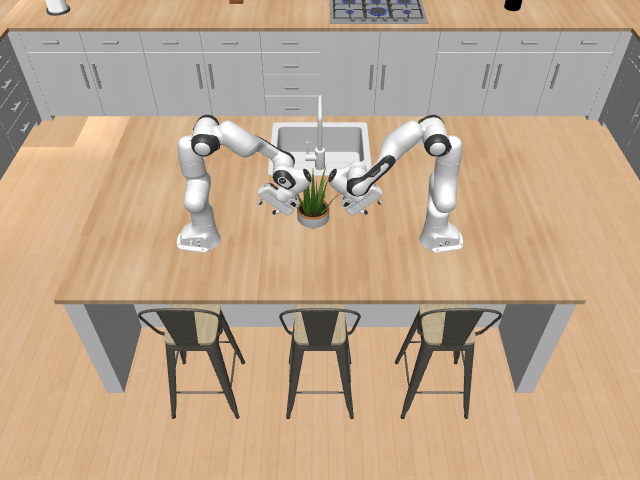

In [12]:
mujoco.mj_forward(model, data)
renderer.update_scene(data, cam)
media.show_image(renderer.render())

In [13]:
# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)
home(data)
import time
import mujoco.viewer
with mujoco.viewer.launch_passive(model, data) as viewer:
    viewer.cam.distance = cam.distance
    viewer.cam.lookat = cam.lookat
    while viewer.is_running():
        mujoco.mj_step(model, data)  # Simulate one step
        viewer.sync()
        time.sleep(0.01)  # Adjust simulation speed
        
del model
del data
del renderer

In [16]:
import mujoco

def print_all_joints(model, data):
    print("\n🔹 All Joints in MuJoCo Model")
    print("------------------------------------------------------")
    print("Index | Joint Name       | Type    | World Position (x, y, z)")
    print("------------------------------------------------------")

    for i in range(model.njnt):  # Loop through all joints
        joint_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, i)
        joint_type = model.jnt_type[i]  # Get joint type (hinge, slide, etc.)
        joint_pos = data.xanchor[i]  # Get joint position in world coordinates

        # Convert joint type to readable format
        joint_type_str = {
            mujoco.mjtJoint.mjJNT_FREE: "free",
            mujoco.mjtJoint.mjJNT_BALL: "ball",
            mujoco.mjtJoint.mjJNT_SLIDE: "slide",
            mujoco.mjtJoint.mjJNT_HINGE: "hinge"
        }.get(joint_type, "unknown")

        print(f"{i:<5} | {joint_name:<15} | {joint_type_str:<6} | {joint_pos}")

# Call the function
print_all_joints(model, data)



🔹 All Joints in MuJoCo Model
------------------------------------------------------
Index | Joint Name       | Type    | World Position (x, y, z)
------------------------------------------------------
0     | joint1_panda0   | hinge  | [ 3.4158     -1.69999785  0.333     ]
1     | joint2_panda0   | hinge  | [ 3.4158     -1.69999785  0.333     ]
2     | joint3_panda0   | hinge  | [ 3.4158     -1.69999785  0.649     ]
3     | joint4_panda0   | hinge  | [ 3.4983     -1.69999816  0.649     ]
4     | joint5_panda0   | hinge  | [ 3.4158     -1.69999785  1.033     ]
5     | joint6_panda0   | hinge  | [ 3.4158     -1.69999785  1.033     ]
6     | joint7_panda0   | hinge  | [ 3.5038     -1.69999818  1.033     ]
7     | finger_joint1_panda0 | slide  | [ 3.5038     -1.69999818  0.8676    ]
8     | finger_joint2_panda0 | slide  | [ 3.5038     -1.69999818  0.8676    ]
9     | joint1_panda1   | hinge  | [ 4.5842     -1.70000215  0.333     ]
10    | joint2_panda1   | hinge  | [ 4.5842     -1.7000021

In [17]:
def print_all_tendons(model, data):
    print("\n🔹 All Tendons in MuJoCo Model")
    print("------------------------------------------------")
    print("Index | Tendon Name    | Length")
    print("------------------------------------------------")

    for i in range(model.ntendon):  # Loop through tendons
        tendon_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_TENDON, i)
        tendon_length = data.ten_length[i]  # Get tendon length
        print(f"{i:<5} | {tendon_name:<15} | {tendon_length:.4f}")

print_all_tendons(model, data)



🔹 All Tendons in MuJoCo Model
------------------------------------------------
Index | Tendon Name    | Length
------------------------------------------------
0     | split_panda0    | 0.0000
1     | split_panda1    | 0.0000


In [18]:
import mujoco

def print_control_mapping(model, data):
    print("\n🔹 Mapping Actuators to Joints/Tendons in MuJoCo")
    print("------------------------------------------------------")
    print("Index | Actuator Name   | Controls (Joint/Tendon)  | ctrl Value")
    print("------------------------------------------------------")

    for i in range(model.nu):  # Iterate over all actuators
        actuator_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i)
        actuator_trntype = model.actuator_trntype[i]
        # Get associated joint or tendon
        id = model.actuator_trnid[i][0]  # Joint ID (-1 if not assigned)

        if actuator_trntype == 0:  # Actuator controls a joint
            target_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_JOINT, id)
        elif actuator_trntype == 3:  # Actuator controls a tendon
            target_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_TENDON, id)
        else:
            target_name = "Unknown"

        control_value = data.ctrl[i]  # Control input for actuator
        print(f"{i:<5} | {actuator_name:<15} | {target_name:<20} | {control_value:.4f} | {model.actuator_trnid[i]}")

# Call the function
print_control_mapping(model, data)



🔹 Mapping Actuators to Joints/Tendons in MuJoCo
------------------------------------------------------
Index | Actuator Name   | Controls (Joint/Tendon)  | ctrl Value
------------------------------------------------------
0     | actuator1_panda0 | joint1_panda0        | 0.0000 | [ 0 -1]
1     | actuator2_panda0 | joint2_panda0        | 0.0000 | [ 1 -1]
2     | actuator3_panda0 | joint3_panda0        | 0.0000 | [ 2 -1]
3     | actuator4_panda0 | joint4_panda0        | 0.0000 | [ 3 -1]
4     | actuator5_panda0 | joint5_panda0        | 0.0000 | [ 4 -1]
5     | actuator6_panda0 | joint6_panda0        | 0.0000 | [ 5 -1]
6     | actuator7_panda0 | joint7_panda0        | 0.0000 | [ 6 -1]
7     | actuator8_panda0 | split_panda0         | 0.0000 | [ 0 -1]
8     | actuator1_panda1 | joint1_panda1        | 0.0000 | [ 9 -1]
9     | actuator2_panda1 | joint2_panda1        | 0.0000 | [10 -1]
10    | actuator3_panda1 | joint3_panda1        | 0.0000 | [11 -1]
11    | actuator4_panda1 | joint4_panda1

In [19]:
model.actuator_trntype

array([0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3], dtype=int32)

In [20]:
# mujoco.mj_saveLastXML("/home/linuxmo/mujoco_sim/mujoco_simenv/test.xml", model)

## Checking for keyframes

1



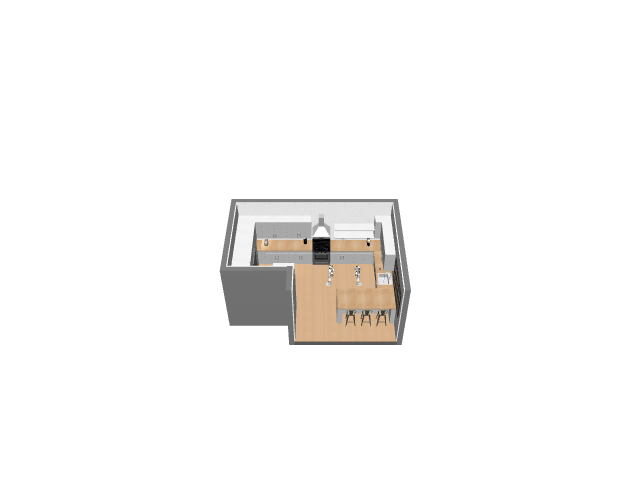

In [21]:
print(model.nkey)
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

## Render!

In [22]:
np.random.seed(12345)

# Rendering options for visual and collision geoms.
vis = mujoco.MjvOption()
vis.geomgroup[2] = True
vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

# Create a camera that will revolve around the robot.
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1
offset = model.vis.global_.azimuth

# Sample actuator noise and smooth it.
nsteps = int(np.ceil(duration / model.opt.timestep))
perturb = np.random.randn(nsteps, model.nu)
width = int(nsteps * ctrl_rate / duration)
kernel = np.exp(-0.5 * np.linspace(-3, 3, width) ** 2)
kernel /= np.linalg.norm(kernel)
for i in range(model.nu):
  perturb[:, i] = np.convolve(perturb[:, i], kernel, mode="same")

# Set the desired control point.
if model.nkey > 0:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  ctrl0 = data.ctrl.copy()
else:
  mujoco.mj_resetData(model, data)
  ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)

frames = []
for i in tqdm(range(nsteps)):
  data.ctrl[:] = ctrl0 + ctrl_std * perturb[i]
  mujoco.mj_step(model, data)
  if len(frames) < data.time * fps:
    camera.azimuth = azimuth(data.time, duration, total_rot, offset)
    renderer.update_scene(data, camera, scene_option=vis)
    vispix = renderer.render().copy().astype(np.float32)
    renderer.update_scene(data, camera, scene_option=coll)
    collpix = renderer.render().copy().astype(np.float32)
    b = blend_coef(data.time, duration, blend_std)
    frame = (1 - b) * vispix + b * collpix
    frame = frame.astype(np.uint8)
    frames.append(frame)
media.show_video(frames, fps=fps, loop=False)

100%|██████████| 5000/5000 [00:04<00:00, 1138.22it/s]


In [ ]:
robot_base_fixture_pose = {'name': 'robot0_base', 'pos': '0.5 -0.8 0', 'quat': '0.707107 0 0 0.707107'}
pos = robot_base_fixture_pose['pos']
pos = list(map(float, pos.split()))

quat = robot_base_fixture_pose['quat']
quat = list(map(float, quat.split()))

pos, quat